In [1]:
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
import os
import io
import re
import sys
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

%matplotlib inline

In [2]:
!python -V

Python 3.7.10


In [3]:
processed_path = '../data/CSE-CIC-IDS2018/processed'
'''
cleaned_csv_files = [
  'TRAIN-1-DATA-IDS-2018-multiclass-bootstrap.csv',
  'TRAIN-2-DATA-IDS-2018-multiclass-bootstrap.csv',
  'TRAIN-3-DATA-IDS-2018-multiclass-bootstrap.csv',
  'TRAIN-4-DATA-IDS-2018-multiclass-bootstrap.csv',
  #'02-20-2018-ddos-loic-tcp.csv'   # WARNING: 4GB FILE.
]

list_of_dataframes = []
for filename in cleaned_csv_files:
    fname = os.path.join(processed_path, filename)
    list_of_dataframes.append(pd.read_csv(fname))

IDS_df = pd.concat(list_of_dataframes)
'''

"\ncleaned_csv_files = [\n  'TRAIN-1-DATA-IDS-2018-multiclass-bootstrap.csv',\n  'TRAIN-2-DATA-IDS-2018-multiclass-bootstrap.csv',\n  'TRAIN-3-DATA-IDS-2018-multiclass-bootstrap.csv',\n  'TRAIN-4-DATA-IDS-2018-multiclass-bootstrap.csv',\n  #'02-20-2018-ddos-loic-tcp.csv'   # WARNING: 4GB FILE.\n]\n\nlist_of_dataframes = []\nfor filename in cleaned_csv_files:\n    fname = os.path.join(processed_path, filename)\n    list_of_dataframes.append(pd.read_csv(fname))\n\nIDS_df = pd.concat(list_of_dataframes)\n"

In [4]:
IDS_df = pd.read_csv("../data/CSE-CIC-IDS2018/processed/CSE-CIC-IDS2018-SampledDataset.csv", low_memory=False)

# To display the top 5 rows/
# IDS_df.head(5)
IDS_df.columns

Index(['dst_port', 'protocol', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_seg_siz

In [5]:
test_df = pd.read_csv(os.path.join(processed_path, 'TEST--DATA-IDS-2018-multiclass.csv'))

In [6]:
#IDS_df = IDS_df.drop('timestamp', axis=1)

In [7]:
for i in range(len(IDS_df.columns)):
      print(IDS_df.columns[i], '-', IDS_df.dtypes[i])

dst_port - int64
protocol - int64
flow_duration - int64
tot_fwd_pkts - int64
tot_bwd_pkts - int64
totlen_fwd_pkts - float64
totlen_bwd_pkts - float64
fwd_pkt_len_max - float64
fwd_pkt_len_min - float64
fwd_pkt_len_mean - float64
fwd_pkt_len_std - float64
bwd_pkt_len_max - float64
bwd_pkt_len_min - float64
bwd_pkt_len_mean - float64
bwd_pkt_len_std - float64
flow_byts_s - float64
flow_pkts_s - float64
flow_iat_mean - float64
flow_iat_std - float64
flow_iat_max - float64
flow_iat_min - float64
fwd_iat_tot - float64
fwd_iat_mean - float64
fwd_iat_std - float64
fwd_iat_max - float64
fwd_iat_min - float64
bwd_iat_tot - float64
bwd_iat_mean - float64
bwd_iat_std - float64
bwd_iat_max - float64
bwd_iat_min - float64
fwd_psh_flags - int64
bwd_psh_flags - int64
fwd_urg_flags - int64
bwd_urg_flags - int64
fwd_header_len - int64
bwd_header_len - int64
fwd_pkts_s - float64
bwd_pkts_s - float64
pkt_len_min - float64
pkt_len_max - float64
pkt_len_mean - float64
pkt_len_std - float64
pkt_len_var - fl

In [8]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(22897324, 79)


In [9]:
print(test_df.shape)

(1612354, 79)


In [10]:
IDS_df.columns

Index(['dst_port', 'protocol', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_seg_siz

In [11]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


In [12]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [13]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(22897324, 79)


In [ ]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

In [ ]:
# print shape before dropping NaN rows
print(IDS_df.shape)

In [11]:
# Finding the null values.
print(test_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


In [12]:
#  first replace infs to NaN:
test_df = test_df.replace([np.inf, -np.inf], np.nan)

In [13]:
# print shape after dropping NaN rows
test_df = test_df.dropna()
print(test_df.shape)
test_df = test_df.reset_index(drop=True)

(1612354, 79)


In [14]:
# Finding the null values.
print(test_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


In [15]:
print(test_df.shape)

(1612354, 79)


Examine the proportion of types of traffic:

In [16]:
IDS_df['label'].value_counts()

Benign                      8435857
DoS attacks-Hulk            2410245
DDoS attacks-LOIC-HTTP      2410245
DDOS attack-HOIC            2410245
DoS attacks-SlowHTTPTest    1205122
FTP-BruteForce              1205122
Bot                         1205122
SSH-Bruteforce              1205122
DoS attacks-GoldenEye       1205122
Infilteration               1205122
Name: label, dtype: int64

In [17]:
test_df['label'].value_counts()

Benign                      1339025
DDOS attack-HOIC              68601
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16064
DoS attacks-SlowHTTPTest      13989
DoS attacks-GoldenEye          4151
Name: label, dtype: int64

In [ ]:
#original_IDS_df = IDS_df
#Y_train = IDS_df.pop("label")
#X_train = IDS_df

In [ ]:
#IDS_df = pd.concat([X_train, Y_train], axis = 1)

In [18]:
IDS_df.shape

(22897324, 79)

In [19]:
# summarize distribution before resampling and augmentation of data
from collections import Counter

counter = Counter(IDS_df["label"])
for k,v in counter.items():
    per = v / len(IDS_df["label"]) * 100
    print('label=%s, n=%d (%.3f%%)' % (k, v, per))

label=Benign, n=8435857 (36.842%)
label=Bot, n=1205122 (5.263%)
label=DDOS attack-HOIC, n=2410245 (10.526%)
label=DDoS attacks-LOIC-HTTP, n=2410245 (10.526%)
label=DoS attacks-GoldenEye, n=1205122 (5.263%)
label=DoS attacks-Hulk, n=2410245 (10.526%)
label=DoS attacks-SlowHTTPTest, n=1205122 (5.263%)
label=FTP-BruteForce, n=1205122 (5.263%)
label=Infilteration, n=1205122 (5.263%)
label=SSH-Bruteforce, n=1205122 (5.263%)


In [ ]:
'''
def get_label(text):    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'DoS attacks-Slowloris':
        return 2
    elif text == 'SSH-Bruteforce':
        return 3
    elif text == 'DDOS attack-HOIC':
        return 4
    elif text == 'FTP-BruteForce':
        return 5
    elif text == 'DoS attacks-SlowHTTPTest':
        return 6
    elif text == 'Bot':
        return 7
    elif text == 'DoS attacks-Hulk':
        return 8
    elif text == 'DoS attacks-GoldenEye':
        return 9
    elif text == 'DDoS attacks-LOIC-HTTP':
        return 10
    elif text == 'DDOS attack-LOIC-UDP':
        return 11
    elif text == 'Brute Force -Web':
        return 12
    elif text == 'Brute Force -XSS':
        return 13
    elif text == 'SQL Injection':
        return 14

IDS_df["label"] = IDS_df["label"].apply(get_label)
test_df["label"] = test_df["label"].apply(get_label)
'''

In [22]:
def get_label(text):    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'SSH-Bruteforce':
        return 2
    elif text == 'DDOS attack-HOIC':
        return 3
    elif text == 'FTP-BruteForce':
        return 4
    elif text == 'DoS attacks-SlowHTTPTest':
        return 5
    elif text == 'Bot':
        return 6
    elif text == 'DoS attacks-Hulk':
        return 7
    elif text == 'DoS attacks-GoldenEye':
        return 8
    elif text == 'DDoS attacks-LOIC-HTTP':
        return 9 
    else :
        return 10

IDS_df["label"] = IDS_df["label"].apply(get_label)
test_df["label"] = test_df["label"].apply(get_label)

In [23]:
IDS_df['label'].value_counts()

0    8435857
3    2410245
7    2410245
9    2410245
1    1205122
2    1205122
4    1205122
5    1205122
6    1205122
8    1205122
Name: label, dtype: int64

In [24]:
test_df['label'].value_counts()

0    1339025
3      68601
9      57619
7      46191
6      28619
4      19336
2      18759
1      16064
5      13989
8       4151
Name: label, dtype: int64

Convert all categorical features into numerical form:

In [31]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        IDS_df[c] = encodings_dictionary[c].fit_transform(IDS_df[c])
        test_df[c] = encodings_dictionary[c].fit_transform(test_df[c])

Use Stratified K Fold to split the data into train and validation

In [32]:
seed = 1234
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = seed)
target = IDS_df.loc[:,'label']

Train-test split the dataset:

In [33]:
def GetPyTorchDataLoaders(x_train, x_test, y_train, y_test, batch_size = 1000):
    # Pytorch
    X_train  = torch.from_numpy(x_train).float()
    Y_train = torch.from_numpy(y_train)

    X_test = torch.from_numpy(x_test).float()
    Y_test = torch.from_numpy(y_test)

    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(X_train, Y_train)
    valid = torch.utils.data.TensorDataset(X_test, Y_test)

    # data loader
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

    print('Completed loading data and returning pytorch train and validation data loaders')
    return train_loader, valid_loader

In [34]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
        
# Defining the DNN model
#input_size = train_loader.dataset.tensors[0].shape[1]
input_size = 78
hidden_layers = [512]
output_size = 10

# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, hidden_layers[0])
        self.activ1 = nn.ReLU()
        
        #self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        #self.activ2 = nn.ReLU()

        #self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2])
        #self.activ3 = nn.ReLU()
        
        self.layer2 = nn.Linear(hidden_layers[0], output_size)
        
    # forward propagate input
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        
        #x = self.layer2(x)
        #x = self.activ2(x)
        
        #x = self.layer3(x)
        #x = self.activ3(x)
        
        x = self.layer2(x)
        return x

model = MLP(input_size)
print(model)
model.to(device)

 # Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)
# Adam Optimizer
learning_rate = 0.0001
#ptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

MLP(
  (layer1): Linear(in_features=78, out_features=512, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=512, out_features=10, bias=True)
)


In [35]:
def train_model(train, test, fold_no):
    print('Start training...')
    start_time = time.time()

    epochs = 1

    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    accuracy_scores = []
    
    # Separate into training data and labels, testing data and labels
    Y_train = train.pop("label").values
    X_train = train.values
    
    Y_test = test.pop("label").values
    X_test = test.values
    
    # Get PyTorch training and validation data loaders
    train_loader, valid_loader = GetPyTorchDataLoaders(X_train, X_test, Y_train, Y_test, batch_size = 5000)

    for e in range(epochs):
        correct_epoch = 0
        total_epoch = 0
        for i, (data, labels) in enumerate(train_loader):
            train = data.to(device)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            if count % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0

                # Iterate through test dataset
                for data, labels in valid_loader:
                    valid = data.to(device)                               
                    labels = labels.to(device)

                    # Forward propagation
                    outputs = model(valid)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                
            if count % 100 == 0:
                # Print Loss
                print('Epoch: {} Iteration: {}  Loss: {}  Accuracy: {} %'.format(e + 1, count, loss.data, accuracy))

            count += 1
              
        # calculate accuracy on the validation set
        # Iterate through test dataset
        for data, labels in valid_loader:
            valid = data.to(device)                               
            labels = labels.to(device)

            # Forward propagation
            outputs = model(valid)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            
            total_epoch += len(labels)
            correct_epoch += (predicted == labels).sum()

        accuracy_epoch = (100 * correct_epoch / float(total_epoch)).item()

        print('Fold',str(fold_no), 'Epoch No. :', e, 'Accuracy for Epoch :', accuracy_epoch)

    end_time = time.time()

    print('Epochs completed. Time taken (seconds): ', str(end_time - start_time))
   
    return accuracy_epoch, loss_list[-1]

In [36]:
accuracy_scores = []
losses = []
fold_no = 1

for train_index, test_index in skf.split(IDS_df, target):
    train = IDS_df.loc[train_index,:]
    test = IDS_df.loc[test_index,:]
    accuracy_score, loss = train_model(train, test, fold_no)
    accuracy_scores.append(accuracy_score)
    losses.append(loss)
    fold_no += 1
    
print('Accuracy score after training on all cross validation sets', accuracy_scores[-1])

Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 379654.71875  Accuracy: 15.127571105957031 %
Epoch: 1 Iteration: 100  Loss: 7457.5830078125  Accuracy: 53.88798522949219 %
Epoch: 1 Iteration: 200  Loss: 3751.503662109375  Accuracy: 62.32538604736328 %
Epoch: 1 Iteration: 300  Loss: 4878.0302734375  Accuracy: 68.67446899414062 %
Epoch: 1 Iteration: 400  Loss: 1842.983642578125  Accuracy: 70.27055358886719 %
Epoch: 1 Iteration: 500  Loss: 3038.842529296875  Accuracy: 67.4834976196289 %
Epoch: 1 Iteration: 600  Loss: 4750.5615234375  Accuracy: 68.40316772460938 %
Epoch: 1 Iteration: 700  Loss: 7142.35205078125  Accuracy: 73.19005584716797 %
Epoch: 1 Iteration: 800  Loss: 3387.7939453125  Accuracy: 71.37740325927734 %
Epoch: 1 Iteration: 900  Loss: 3209.040283203125  Accuracy: 78.97047424316406 %
Epoch: 1 Iteration: 1000  Loss: 3489.839111328125  Accuracy: 62.08995056152344 %
Epoch: 1 Iteration: 1100  Loss: 5720.0

Epoch: 1 Iteration: 1300  Loss: 2445.16650390625  Accuracy: 85.37554168701172 %
Epoch: 1 Iteration: 1400  Loss: 2588.74658203125  Accuracy: 79.65557098388672 %
Epoch: 1 Iteration: 1500  Loss: 1474.6802978515625  Accuracy: 74.80278015136719 %
Epoch: 1 Iteration: 1600  Loss: 3794.645263671875  Accuracy: 85.5731201171875 %
Epoch: 1 Iteration: 1700  Loss: 2432.41650390625  Accuracy: 82.88275909423828 %
Epoch: 1 Iteration: 1800  Loss: 2527.83447265625  Accuracy: 86.22402954101562 %
Epoch: 1 Iteration: 1900  Loss: 1331.4285888671875  Accuracy: 83.29110717773438 %
Epoch: 1 Iteration: 2000  Loss: 3515.8701171875  Accuracy: 83.00841522216797 %
Epoch: 1 Iteration: 2100  Loss: 4945.97802734375  Accuracy: 84.56151580810547 %
Epoch: 1 Iteration: 2200  Loss: 1189.671142578125  Accuracy: 81.41971588134766 %
Epoch: 1 Iteration: 2300  Loss: 1906.7967529296875  Accuracy: 81.13430786132812 %
Epoch: 1 Iteration: 2400  Loss: 3576.802490234375  Accuracy: 83.60978698730469 %
Epoch: 1 Iteration: 2500  Loss: 5

Epoch: 1 Iteration: 2700  Loss: 1795.9508056640625  Accuracy: 83.52134704589844 %
Epoch: 1 Iteration: 2800  Loss: 1831.045654296875  Accuracy: 74.05508422851562 %
Epoch: 1 Iteration: 2900  Loss: 2442.784912109375  Accuracy: 84.27130889892578 %
Epoch: 1 Iteration: 3000  Loss: 1081.5440673828125  Accuracy: 81.9794692993164 %
Epoch: 1 Iteration: 3100  Loss: 1045.396240234375  Accuracy: 72.03607177734375 %
Epoch: 1 Iteration: 3200  Loss: 1350.17138671875  Accuracy: 85.96394348144531 %
Epoch: 1 Iteration: 3300  Loss: 642.5394287109375  Accuracy: 77.11588287353516 %
Epoch: 1 Iteration: 3400  Loss: 2854.214111328125  Accuracy: 82.75029754638672 %
Epoch: 1 Iteration: 3500  Loss: 3644.699951171875  Accuracy: 88.5525894165039 %
Epoch: 1 Iteration: 3600  Loss: 995.8572998046875  Accuracy: 83.4512939453125 %
Epoch: 1 Iteration: 3700  Loss: 1793.58642578125  Accuracy: 83.07015991210938 %
Epoch: 1 Iteration: 3800  Loss: 3864.288330078125  Accuracy: 77.44640350341797 %
Epoch: 1 Iteration: 3900  Loss:

Epoch: 1 Iteration: 4000  Loss: 2857.91455078125  Accuracy: 82.54267883300781 %
Epoch: 1 Iteration: 4100  Loss: 1270.3221435546875  Accuracy: 86.50741577148438 %
Fold 7 Epoch No. : 0 Accuracy for Epoch : 82.38335418701172
Epochs completed. Time taken (seconds):  2055.5274481773376
Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 2192.41650390625  Accuracy: 81.49604034423828 %
Epoch: 1 Iteration: 100  Loss: 774.2271728515625  Accuracy: 79.78353118896484 %
Epoch: 1 Iteration: 200  Loss: 3993.279541015625  Accuracy: 87.20919799804688 %
Epoch: 1 Iteration: 300  Loss: 4587.07177734375  Accuracy: 84.36415100097656 %
Epoch: 1 Iteration: 400  Loss: 1515.619873046875  Accuracy: 88.74348449707031 %
Epoch: 1 Iteration: 500  Loss: 1927.3204345703125  Accuracy: 88.69745635986328 %
Epoch: 1 Iteration: 600  Loss: 2143.126708984375  Accuracy: 88.5042495727539 %
Epoch: 1 Iteration: 700  Loss: 1842.5419921875  Accuracy: 77.4026

Epoch: 1 Iteration: 900  Loss: 1167.20263671875  Accuracy: 88.46882629394531 %
Epoch: 1 Iteration: 1000  Loss: 2346.8740234375  Accuracy: 87.08870697021484 %
Epoch: 1 Iteration: 1100  Loss: 1811.8145751953125  Accuracy: 82.83624267578125 %
Epoch: 1 Iteration: 1200  Loss: 3120.365234375  Accuracy: 88.42803192138672 %
Epoch: 1 Iteration: 1300  Loss: 2166.7841796875  Accuracy: 85.20451354980469 %
Epoch: 1 Iteration: 1400  Loss: 3321.013916015625  Accuracy: 88.4079818725586 %
Epoch: 1 Iteration: 1500  Loss: 1721.1573486328125  Accuracy: 86.94017028808594 %
Epoch: 1 Iteration: 1600  Loss: 1277.5701904296875  Accuracy: 88.23735809326172 %
Epoch: 1 Iteration: 1700  Loss: 1170.7364501953125  Accuracy: 86.89680480957031 %
Epoch: 1 Iteration: 1800  Loss: 2760.3115234375  Accuracy: 74.45089721679688 %
Epoch: 1 Iteration: 1900  Loss: 2156.677490234375  Accuracy: 89.173583984375 %
Epoch: 1 Iteration: 2000  Loss: 3226.25732421875  Accuracy: 87.1295394897461 %
Epoch: 1 Iteration: 2100  Loss: 527.7924

In [37]:
print('Accuracy score across after stratified K Fold validation and training', accuracy_scores[-1])

Accuracy score across after stratified K Fold validation and training 86.33695983886719


In [38]:
def GetPyTorchTestDataLoader(test_data, test_labels, batch_size=1000):
    # Pytorch

    X_test = torch.from_numpy(test_data).float()
    Y_test = torch.from_numpy(test_labels)

    # Pytorch train and test sets
    test = torch.utils.data.TensorDataset(X_test, Y_test)

    # data loader
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    print('Completed loading data and returning pytorch test data loaders')
    return test_loader

In [39]:
test_labels = test_df.pop("label").values
test_data = test_df.values

In [40]:
test_loader = GetPyTorchTestDataLoader(test_data, test_labels, batch_size=5000)

Completed loading data and returning pytorch test data loaders


In [41]:
def plot_confusion_matrix(conf_matrix, label_names):
    '''Plot confusion matrix
    # param conf_matrix: confusion matrix nd array
    # return: None
    '''
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.7)
    # show all ticks
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    # label them with the respective list entries
    ax.set_xticklabels(label_names,  rotation=45)
    ax.set_yticklabels(label_names)
    
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i,j], va='center', ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

Completed loading data and returning pytorch train and validation data loaders

In [42]:
# Aggregate all predictions in this torch tensor 
all_labels = torch.LongTensor([]).to(device)
all_predictions = torch.LongTensor([]).to(device)

for data, label in test_loader:
    valid = data.to(device)                               
    label = label.to(device)

    # Forward propagation
    outputs = model(valid)

    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]
    
    all_predictions = torch.cat(
        (all_predictions, predicted),
        dim =0
    )
    all_labels = torch.cat(
        (all_labels, label),
        dim =0
    )

In [43]:
print(all_labels.size())
print(all_predictions.size())

torch.Size([1612354])
torch.Size([1612354])


In [44]:
LABEL_TO_ID = {  
    "Benign": 0,
    'Infilteration': 1,
    'SSH-Bruteforce': 2,
    'DDOS attack-HOIC': 3,
    'FTP-BruteForce': 4,
    'DoS attacks-SlowHTTPTest': 5,
    'Bot': 6,
    'DoS attacks-Hulk': 7,
    'DoS attacks-GoldenEye': 8,
    'DDoS attacks-LOIC-HTTP': 9    
}

ID_TO_LABEL = {
    v: k for k, v in LABEL_TO_ID.items()
}

In [45]:
label_names = []
for i in range(10):
    label_names.append(ID_TO_LABEL[i])

In [46]:
print(label_names)

['Benign', 'Infilteration', 'SSH-Bruteforce', 'DDOS attack-HOIC', 'FTP-BruteForce', 'DoS attacks-SlowHTTPTest', 'Bot', 'DoS attacks-Hulk', 'DoS attacks-GoldenEye', 'DDoS attacks-LOIC-HTTP']


Converting predictions torch tensor to numpy array
Plotting confusion matrix for test data


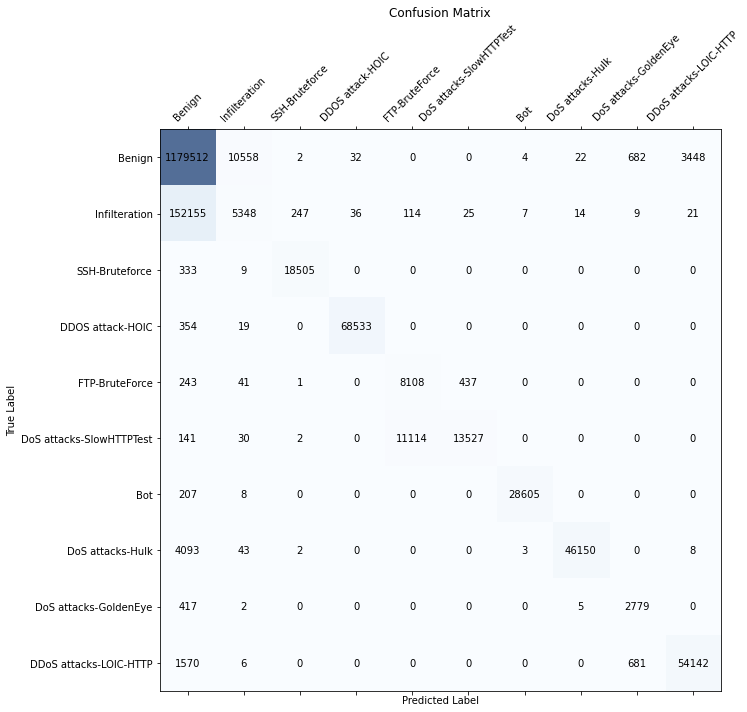

In [47]:
print('Converting predictions torch tensor to numpy array')
all_preds_np = all_predictions.cpu().data.numpy()
all_labels_np = all_labels.cpu().data.numpy()

# print the confusion matrix for this epoch and fold
print('Plotting confusion matrix for test data')
cnf_matrix = confusion_matrix(all_preds_np, all_labels_np, labels=[x for x in range(10)])
plot_confusion_matrix(cnf_matrix, label_names)    

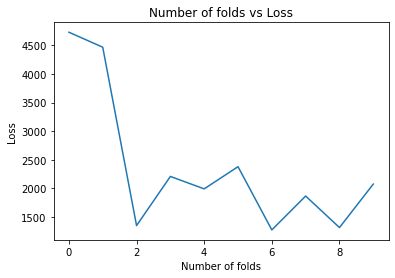

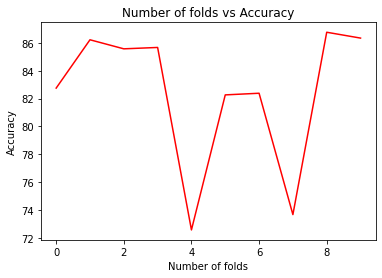

In [48]:
plt.plot(losses)
plt.xlabel("Number of folds")
plt.ylabel("Loss")
plt.title("Number of folds vs Loss")
plt.show()

# visualization accuracy 
plt.plot(accuracy_scores, color = "red")
plt.xlabel("Number of folds")
plt.ylabel("Accuracy")
plt.title("Number of folds vs Accuracy")
plt.show()